In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analytics-vidhya-job-a-thon-may-2021/train_s3TEQDk.csv
/kaggle/input/analytics-vidhya-job-a-thon-may-2021/test_mSzZ8RL.csv


In [2]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../input/analytics-vidhya-job-a-thon-may-2021/train_s3TEQDk.csv') # train data
ts = pd.read_csv('../input/analytics-vidhya-job-a-thon-may-2021/test_mSzZ8RL.csv') # test data

In [4]:
ts_id = ts['ID']
ts_id

0         VBENBARO
1         CCMEWNKY
2         VK3KGA9M
3         TT8RPZVC
4         SHQZEYTZ
            ...   
105307    DBENJOYI
105308    CWQ72DWS
105309    HDESC8GU
105310    2PW4SFCA
105311    F2NOYPPZ
Name: ID, Length: 105312, dtype: object

In [5]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [6]:
df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [7]:
print(df.isnull().sum())
print('#############################')
print(ts.isnull().sum())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64
#############################
ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64


In [8]:
# Credit_Product: If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
# Thus, We will replace null values with 'No' because if the customer has active credit product, data would have been fed.

df['Credit_Product'] = df['Credit_Product'].replace(np.nan, 'No')
ts['Credit_Product'] = ts['Credit_Product'].replace(np.nan, 'No')

In [9]:
# The classes are heavily skewed we need to solve this issue later.
print('Customer is not interested:', round(df['Is_Lead'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Customer is interested:', round(df['Is_Lead'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Customer is not interested: 76.28 % of the dataset
Customer is interested: 23.72 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: Customer is not interested || 1: Customer is interested)')

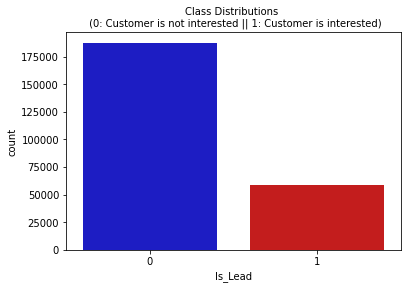

In [10]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Is_Lead', data=df, palette=colors)
plt.title('Class Distributions \n (0: Customer is not interested || 1: Customer is interested)', fontsize=10)

In [11]:
df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

<AxesSubplot:xlabel='Age', ylabel='Density'>

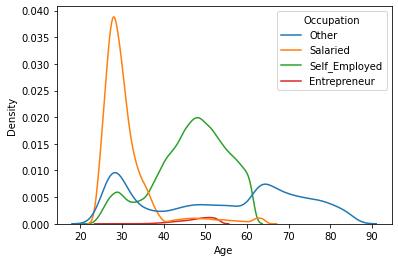

In [12]:
sns.kdeplot(data=df, x="Age", hue='Occupation')

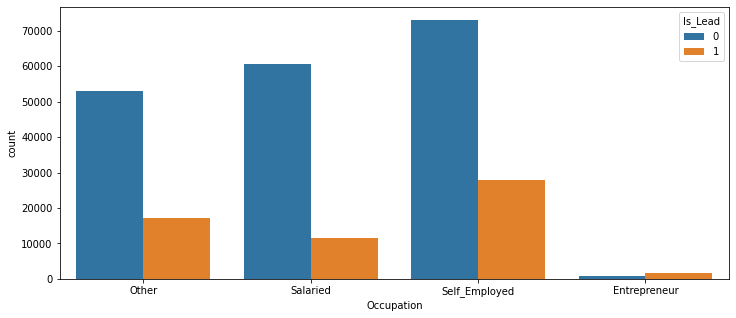

In [13]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x= 'Occupation', hue= 'Is_Lead')
plt.show()

Text(0.5, 0, 'Age')

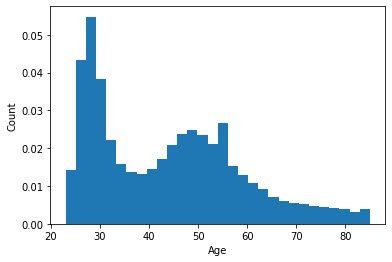

In [14]:
plt.hist(df.Age, density=True, bins=30)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Age')

In [15]:
df = df.drop(['ID', 'Region_Code'], axis = 1)

df.head()

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,Other,X3,43,No,1045696,No,0
1,Female,30,Salaried,X1,32,No,581988,No,0
2,Female,56,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,Salaried,X1,19,No,470454,No,0
4,Female,30,Salaried,X1,33,No,886787,No,0


In [16]:
ts = ts.drop(['ID', 'Region_Code'], axis = 1)

ts.head()

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Male,29,Other,X1,25,Yes,742366,No
1,Male,43,Other,X2,49,No,925537,No
2,Male,31,Salaried,X1,14,No,215949,No
3,Male,29,Other,X1,33,No,868070,No
4,Female,29,Other,X1,19,No,657087,No


In [17]:
df = pd.get_dummies(df, columns = ['Gender', 'Occupation', 'Credit_Product', 'Channel_Code', 'Is_Active'], drop_first = True)

In [18]:
ts = pd.get_dummies(ts, columns = ['Gender', 'Occupation', 'Credit_Product', 'Channel_Code', 'Is_Active'], drop_first = True)

In [19]:
df.columns

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead', 'Gender_Male',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Credit_Product_Yes', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes'],
      dtype='object')

In [20]:
df = df[['Age', 'Vintage', 'Avg_Account_Balance', 'Gender_Male',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Credit_Product_Yes', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes', 'Is_Lead']]

In [21]:
df.columns

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Gender_Male',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Credit_Product_Yes', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes', 'Is_Lead'],
      dtype='object')

In [22]:
X = df.drop('Is_Lead', axis=1)
y = df['Is_Lead']

In [23]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=42)

In [24]:
X_res, y_res = os.fit_resample(X, y)

In [25]:
X_res.shape[0], y_res.shape[0]

(374874, 374874)

In [26]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 187437, 1: 58288})
Resampled dataset shape Counter({0: 187437, 1: 187437})


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [28]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [29]:
vsdfvsfvs

NameError: name 'vsdfvsfvs' is not defined

In [30]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression : 0.8806402134044682
Confusion Matrix : 
[[30052  7507]
 [ 1442 35974]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     37559
           1       0.83      0.96      0.89     37416

    accuracy                           0.88     74975
   macro avg       0.89      0.88      0.88     74975
weighted avg       0.89      0.88      0.88     74975



In [31]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
y_pred = ada_classifier.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression : 0.6900166722240747
Confusion Matrix : 
[[23798 13761]
 [ 9480 27936]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.72      0.63      0.67     37559
           1       0.67      0.75      0.71     37416

    accuracy                           0.69     74975
   macro avg       0.69      0.69      0.69     74975
weighted avg       0.69      0.69      0.69     74975



In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression : 0.7477292430810271
Confusion Matrix : 
[[25122 12437]
 [ 6477 30939]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73     37559
           1       0.71      0.83      0.77     37416

    accuracy                           0.75     74975
   macro avg       0.75      0.75      0.75     74975
weighted avg       0.75      0.75      0.75     74975



In [33]:
from sklearn.linear_model import LogisticRegression
log_classifier=LogisticRegression()
log_classifier.fit(X_train, y_train)
y_pred = log_classifier.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression : 0.661407135711904
Confusion Matrix : 
[[22066 15493]
 [ 9893 27523]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.69      0.59      0.63     37559
           1       0.64      0.74      0.68     37416

    accuracy                           0.66     74975
   macro avg       0.67      0.66      0.66     74975
weighted avg       0.67      0.66      0.66     74975



#### Best threshold for maximum accuracy

In [34]:
final_prediction=rf_model.predict_proba(X_test)[:,1]

In [35]:
#### Calculate the ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
thresholds

array([2.        , 1.        , 0.998     , 0.996     , 0.994     ,
       0.992     , 0.99      , 0.988     , 0.986     , 0.984     ,
       0.982     , 0.98      , 0.97980952, 0.978     , 0.976     ,
       0.97483333, 0.974     , 0.972     , 0.97      , 0.968     ,
       0.966     , 0.964     , 0.9625    , 0.962     , 0.96      ,
       0.958     , 0.956     , 0.954     , 0.952     , 0.95      ,
       0.948     , 0.94661667, 0.946     , 0.944     , 0.942     ,
       0.94      , 0.938     , 0.936     , 0.934     , 0.932     ,
       0.93      , 0.928     , 0.926     , 0.924     , 0.922     ,
       0.92      , 0.918     , 0.916     , 0.914     , 0.912     ,
       0.91      , 0.908     , 0.906     , 0.904     , 0.902     ,
       0.9       , 0.898     , 0.896     , 0.894     , 0.892     ,
       0.89      , 0.888     , 0.886     , 0.884     , 0.882     ,
       0.881     , 0.88      , 0.878     , 0.876     , 0.874     ,
       0.872     , 0.87      , 0.868     , 0.86746667, 0.866  

In [36]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

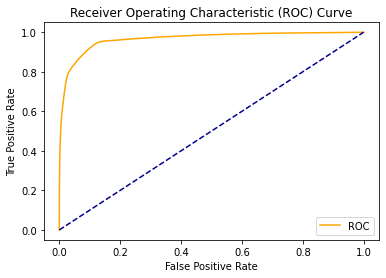

In [37]:
plot_roc_curve(fpr,tpr)

In [38]:
ts_pred = rf_model.predict_proba(ts)

In [39]:
ts_pred

array([[0.364, 0.636],
       [0.478, 0.522],
       [0.076, 0.924],
       ...,
       [0.084, 0.916],
       [0.814, 0.186],
       [0.076, 0.924]])

In [40]:
result = pd.DataFrame({"ID": ts_id, "Is_Lead": ts_pred[:,1]})

In [41]:
result.to_csv("submission_proba.csv", index=False)

In [42]:
from IPython.display import FileLink

FileLink('submission_proba.csv')

/kaggle/working/submission_proba.csv